In [113]:
import numpy as np

from typing import Optional
from os import path

import numpy as np


import gym
from gym import spaces
from gym.utils import seeding

import pendulum


class PendulumEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}

    def __init__(self, g=10.0):
        self.max_speed = 8
        self.max_torque = 2.0
        self.dt = 0.05
        self.g = g
        self.m = 1.0
        self.l = 1.0
        self.viewer = None

        high = np.array([1.0, 1.0, self.max_speed], dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, u):
        th, thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        dt = self.dt

        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        costs = angle_normalize(th) ** 2 + 0.1 * thdot ** 2 + 0.001 * (u ** 2)

        newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l ** 2) * u) * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * dt

        self.state = np.array([newth, newthdot])
        return self._get_obs(), -costs, False, {}

    def reset(self):
        high = np.array([np.pi, 1])
        self.state = self.np_random.uniform(low=-high, high=high)
        self.state = np.array([1.0,0.0])

        self.last_u = None
        return self._get_obs()

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([np.cos(theta), np.sin(theta), thetadot], dtype=np.float32)

    def render(self, mode="human"):
        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(500, 500)
            self.viewer.set_bounds(-2.2, 2.2, -2.2, 2.2)
            rod = rendering.make_capsule(1, 0.2)
            rod.set_color(0.8, 0.3, 0.3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(0.05)
            axle.set_color(0, 0, 0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1.0, 1.0)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi / 2)
        if self.last_u is not None:
            self.imgtrans.scale = (-self.last_u / 2, np.abs(self.last_u) / 2)

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi




In [114]:
class PendulumDAEEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}

    def __init__(self, g=10.0):
        self.max_speed = 8
        self.max_torque = 2.0
        self.dt = 0.05
        self.g = g
        self.m = 1.0
        self.l = 1.0
        self.viewer = None

        high = np.array([1.0, 1.0, self.max_speed], dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed()
        
        self.dae = pendulum.model()
        self.dae.Dt = self.dt

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, u):
        th, thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        dt = self.dt
        self.t += dt

        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        costs = angle_normalize(th) ** 2 + 0.1 * thdot ** 2 + 0.001 * (u ** 2)

        #newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
        #newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        #newth = th + newthdot * dt
        
        self.dae.run(self.t,{'u':u,'M':self.m,'G':self.g})
        

        #self.state = np.array([newth, newthdot])
        self.state = self.dae.get_mvalue(['theta','omega'])
        
        return self._get_obs(), -costs, False, {}

    def reset(self):
        high = np.array([np.pi, 1])
        #self.state = self.np_random.uniform(low=-high, high=high)
        self.state = np.array([1.0,0.0])
        self.last_u = None
        
        self.dae.ini({})    
        
        
        self.dae.xy[:2] = self.state
        self.t = 0.0 
        
        
        return self._get_obs()
    


    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([np.cos(theta), np.sin(theta), thetadot], dtype=np.float32)

    def render(self, mode="human"):
        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(500, 500)
            self.viewer.set_bounds(-2.2, 2.2, -2.2, 2.2)
            rod = rendering.make_capsule(1, 0.2)
            rod.set_color(0.8, 0.3, 0.3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(0.05)
            axle.set_color(0, 0, 0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1.0, 1.0)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi / 2)
        if self.last_u is not None:
            self.imgtrans.scale = (-self.last_u / 2, np.abs(self.last_u) / 2)

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        
        self.dae.post()
        if self.viewer:
            self.viewer.close()
            self.viewer = None


def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi






def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi


In [115]:
gym_pendulum = PendulumEnv()

dae_pendulum = PendulumDAEEnv()


In [116]:
gym_pendulum.reset()

array([0.5403023 , 0.84147096, 0.        ], dtype=float32)

In [117]:
dae_pendulum.reset()

array([0.5403023 , 0.84147096, 0.        ], dtype=float32)

In [118]:
times = np.arange(0,100,0.5)

In [119]:
#%%timeit
gym_pendulum.reset()

gym_state_list = []
for t in times:
    gym_pendulum.step(np.array([0.1]))
    gym_state_list += [gym_pendulum.state]

In [120]:
#%%timeit
dae_pendulum.reset()

dae_state_list = []
for t in times:
    dae_pendulum.step(np.array([0.1]))
    #print(dae_pendulum.state)
    dae_state_list += [dae_pendulum.state]

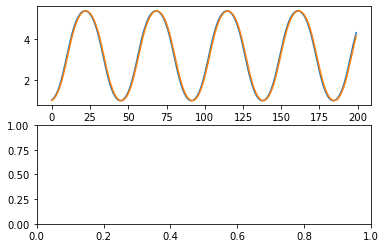

In [121]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2)
axes[0].plot([item[0] for item in  gym_state_list])
axes[0].plot([item[0] for item in  dae_state_list])
#axes[1].plot([item[2] for item in  s_list])